# Inter-subjects correlation and dynamical correlation (figure 1)

In [55]:

import h5py
import mne
import numpy as np
import scipy.stats as stats
import scipy
import pandas as pd
from os.path import join as pjoin
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import matplotlib.cm as cm
import random
import os
import pickle
import warnings 
import matplotlib
from lempel_ziv_complexity import lempel_ziv_complexity
import seaborn as sns

import saving as sv
import mattepy as mp
import utils_avalanches as av
import Utils_FC as fc

warnings.simplefilter('ignore')

#path='/home/jeremy/anaconda3/matteo/'
path='C:/Users/matte/OneDrive/Documenti/matteo/'
#CREATING THE LIST OF SUBJECTS

Computation subject list 

In [56]:

sound_list=['rest','music','speech']
arr_mu = os.listdir(path +'seeg_fif_data/music')
arr_rest = os.listdir(path +'seeg_fif_data/speech')
arr_speech = os.listdir(path +'seeg_fif_data/rest')

subject_set_mu=set()
subject_set_speech=set()
subject_set_rest=set()

for st in arr_mu: 
    #print(st)
    subject_set_mu.add(st.partition('_')[0])
    #print(st.partition('_')[0])
    
for st in arr_speech:
    subject_set_speech.add(st.partition('_')[0])
    
for st in arr_rest:
    subject_set_rest.add(st.partition('_')[0])

subject_list=list(subject_set_mu.intersection(subject_set_speech,subject_set_rest))

#Here I create a set of the  all channels
total_channels_set=set()

for subject in subject_list:
    with h5py.File(pjoin(path +'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
        #print(f.keys())
        #print('chnames', f['chnames'].shape)
        
        chnames = f['chnames'][...].astype('U')
        total_channels_set.update(chnames)
        
#print(total_channels_set)


#Here I create a set of the H channels
ch_H=set()
for ch in total_channels_set:
    
    if "H" in ch:
        ch_H.add(ch)

#Here I create another set of channels        
ch_IM=set()
for ch in total_channels_set:
    
    if "IP" in ch:
        ch_IM.add(ch)
#print(ch_H)





In [57]:
ch_H_i={}
zdata={}
for isub, subject in enumerate(subject_list):
    print(subject)
    zdata[subject]={}
    
    
    with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
        #print(f.keys())
        #print('chnames', f['chnames'].shape)

        chnames = f['chnames'][...].astype('U')
        x=f['chlocs']

    #Here we load the list of bad channels
    with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
        #print(f.keys())
        #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

        bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
        #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

    ## Cleaning from artifacts
    #List of bad channels indices
    ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

    clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
    ch_H_i[subject]= [i for i, ch in enumerate(clean_chnames) if ch in ch_H]
    
    print(ch_H_i[subject])
    
sv.saving(ch_H_i, path+"H_channels_indices_subjects")
    
    

sub-9d783b836f5e
[18, 19, 20, 21, 22, 23, 24, 25, 26, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]
sub-3ef8645f99c5
[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
sub-fccb4adbfadc
[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
sub-14c725b6b803
[29, 30, 31, 32, 33, 34, 35, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]
sub-ebf231d97f73
[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 139, 140, 141, 142, 143, 144, 145]
sub-4247d6d6cdbf
[31, 32, 33, 34, 35, 36, 37, 38, 39, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
sub-e0bb6ccef2a5
[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
sub-44375d501493
[100, 101, 102, 103, 104, 105, 106]
sub-a4e7fc9daa96
[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
sub-82e330f8aadd
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
sub-cacae171ee15
[28, 29, 30, 31, 3

In [23]:

#PARAMETERS

subject_list=subject_list

final_channels_without_H={}

final_channels_H={}

final_channels_all={}

dataused='simple'

datatipe="hgenv_down100"


zdata={}

ch_H_i={}
for isub, subject in enumerate(subject_list):
    
    zdata[subject]={}
    
    for sound in sound_list:
    
        ## Load the data from the HDF fil
        #print(subject, isub)    
        #Loading the data
        with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('music', f['music'].shape)

            #data_music[subject]=f['music'][...]
            data_raw=f[sound][...]
            
            #Here we delete the time point of the rest that correspond to the end and beginning of the three sessions
            if sound=='rest':
                index_del=np.concatenate((np.arange(int(len(data_raw[0,:])/3)-200,int(len(data_raw[0,:])/3)+200),np.arange(int(len(data_raw[0,:])*2/3)-200,int(len(data_raw[0,:])*2/3)+200)))   
                data_raw=np.delete(data_raw, index_del, axis=1)

            data_raw=data_raw[:,100:-100]

        #Here we load the channels names
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
            print(f.keys())
            print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            print(f.keys())
            print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]

        clean= np.delete(data_raw, ch_i, axis=0)

        #List of indices of H channels, list of indices of not H channels
        ch_H_i[subject]= [i for i, ch in enumerate(clean_chnames) if ch not in ch_H]
        ch_H_w_i= [i for i, ch in enumerate(clean_chnames) if ch in ch_H]

        #dictionaries with subjects ad keys and channels names
        final_channels_without_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i in ch_H_i[subject]]
        final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in ch_H_i[subject]]
        final_channels_all[subject]=clean_chnames

        #The final channels that we used
        final_channels=clean_chnames


        #HERE WE CREATE THE DATA SET, THAT WE USE
        #only the channels in Helsch gyrus
        clean_H = np.delete(clean, ch_H_i[subject], axis=0)

        #only the channels not in the helsch gyrus
        clean_without_H = np.delete(clean, ch_H_w_i, axis=0)

        #clean_mu=clean2(clean_music_H, N=3)
        #clean_sp=clean2(clean_speech_H, N=3)
        #clean_re=clean2(clean_rest_H, N=3)

        #zscore of the data
        zdata_art=stats.zscore(clean, axis=1)

        #the artifacts are substituted by 0
        zdata_=np.where(np.abs(zdata_art)>5, 0, zdata_art)

        #zscored computed again
        zdata[subject][sound]=stats.zscore(zdata_, axis=1)
    
#sv.saving(zdata, path+"data_subject_sound_" + datatipe)
#sv.saving(ch_H_i, path+"H_channels_indices_subjects")



<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (170,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (47,), type "|S10">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (170,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (47,), type "|S10">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (170,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (47,), type "|S10">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (192,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'out

In [8]:
len(subject_list)


19

speech
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 98, 99, 100, 101, 102, 103, 104]
[12, 13, 14, 15, 16, 17, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 70, 71, 72, 73, 74, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]
[19, 20, 21, 22, 23, 24, 25, 113, 114, 115, 116, 117, 118]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,

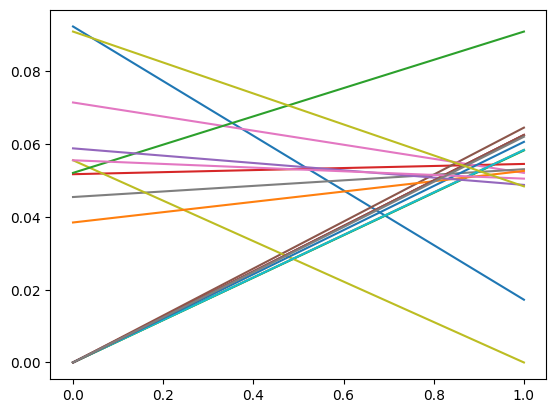

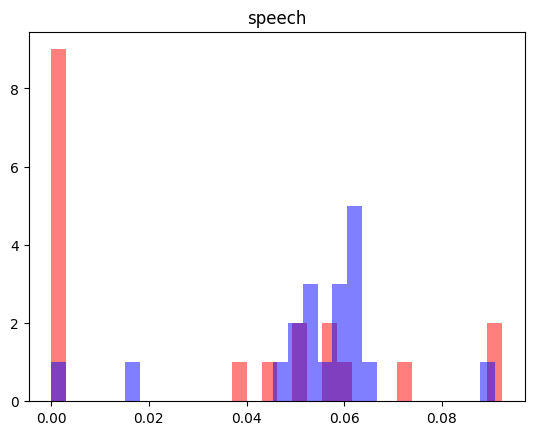

music
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 98, 99, 100, 101, 102, 103, 104]
[12, 13, 14, 15, 16, 17, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 70, 71, 72, 73, 74, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]
[19, 20, 21, 22, 23, 24, 25, 113, 114, 115, 116, 117, 118]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 

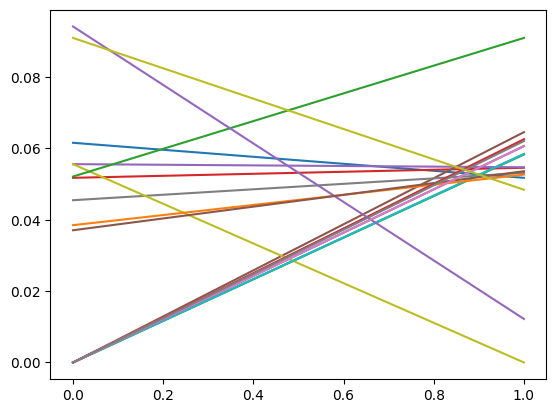

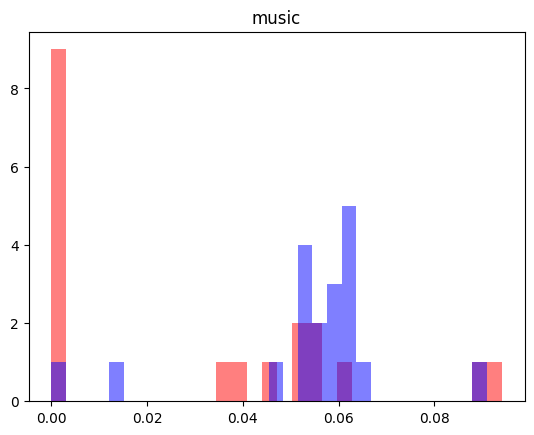

rest
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 98, 99, 100, 101, 102, 103, 104]
[12, 13, 14, 15, 16, 17, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 70, 71, 72, 73, 74, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]
[19, 20, 21, 22, 23, 24, 25, 113, 114, 115, 116, 117, 118]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 1

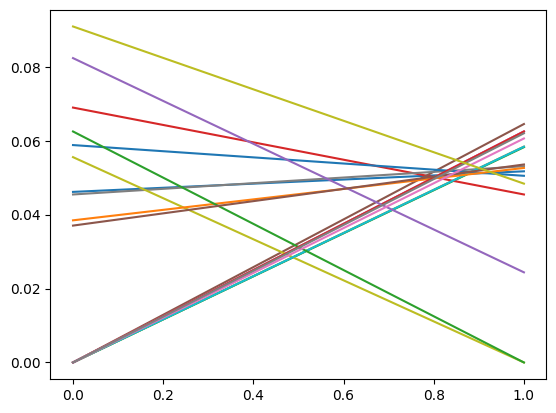

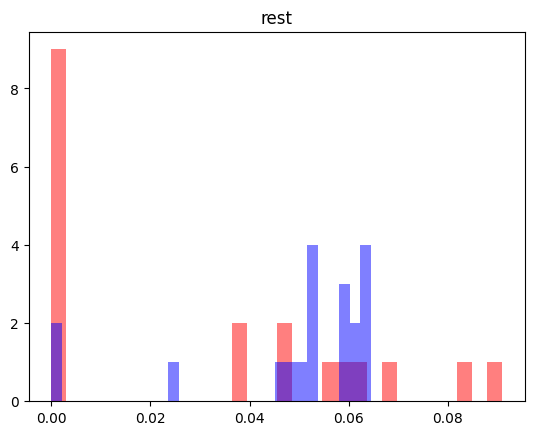

In [54]:
right_eng={}
left_eng={}

sum_right={}
sum_left={}



for o, sound in enumerate(['speech','music', 'rest']):
    right_eng[sound]=[]
    left_eng[sound]=[]
    sum_left[sound]=[]
    sum_right[sound]=[]
        
    print(sound) 
    
    for isub,subject in enumerate(subject_list):

        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            #print(f.keys())
            #print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']


        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

        ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

        chnames=chnames[ch_i]

        # collect coordinates for this specific orientation (only one patient)
       

        # make sure you only select the left electrodes for the left orientation and
        # right electrodes for the right orientation
        if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
            chnames = np.array([x.replace('Ip', "IP") for x in chnames])
            chnames = np.array([x.replace('p', "'") for x in chnames])
            chnames = np.array([x.replace('PIP', "PI'") for x in chnames])     


        _, _, left_i, right_i = mp.split_hemis(chnames)

        thres=np.percentile(zdata[subject]['rest'], 99)

        aval=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)
        bin_matrix=aval['Zbin'].T
        #print(bin_matrix.shape, len(ch_i))
        n_regions, n_time=bin_matrix.shape

        engag=np.sum(bin_matrix, axis=1)/n_time


        percen=np.percentile(engag, 95)

        print(right_i)
        print(left_i)

        sum_right[sound].append(np.sum(np.where(engag[right_i]>percen,1,0))/len(right_i))
        sum_left[sound].append(np.sum(np.where(engag[left_i]>percen,1,0))/len(left_i))
        plt.plot([np.sum(np.where(engag[right_i]>percen,1,0))/len(right_i), np.sum(np.where(engag[left_i]>percen,1,0))/len(left_i)])

        right_eng[sound].append(engag[right_i])
        left_eng[sound].append(engag[left_i])

        #plt.hist(engag[right_i], bins=30, alpha=0.4)
        #plt.hist(engag[left_i], bins=30, alpha=0.4)
        #plt.show()
        #plt.close()
    
    right_eng[sound]=np.array(right_eng[sound])
    left_eng[sound]=np.array(left_eng[sound])
    
    re=right_eng[sound][0]
    for i in range(len(right_eng[sound])-1):
        re=np.concatenate((re, right_eng[sound][i+1]))

    le=left_eng[sound][0]
    for i in range(len(left_eng[sound])-1):
        le=np.concatenate((le, left_eng[sound][i+1]))

    print(len(re),len(le))

    

    #plt.title(sound)
    #plt.hist(re, bins=30, alpha=0.5, color='r')
    #plt.hist(le, bins=30, alpha=0.5, color='b')
    #plt.show()
    #plt.close()
    plt.show()
    plt.close()
    plt.title(sound)
    plt.hist(sum_right[sound], bins=30, alpha=0.5, color='r')
    plt.hist(sum_left[sound], bins=30, alpha=0.5, color='b')
    plt.show()
    plt.close()
    
    

        
        
        

[0.017241379310344827, 0.05172413793103448]
[0.058394160583941604, 0.058394160583941604]
[0.05825242718446602, 0.05825242718446602]
[0.05454545454545454, 0.05454545454545454]
[0.0625, 0.0546875]
[0.06451612903225806, 0.06451612903225806]
[0.052083333333333336, 0.0625]
[0.05309734513274336, 0.05309734513274336]
[0.0, 0.0]
[0.058394160583941604, 0.058394160583941604]
[0.06060606060606061, 0.06060606060606061]
[0.05263157894736842, 0.05263157894736842]
[0.09090909090909091, 0.09090909090909091]
[0.0625, 0.0625]
[0.04878048780487805, 0.012195121951219513]
[0.0625, 0.05357142857142857]
[0.050505050505050504, 0.06060606060606061]
[0.06201550387596899, 0.06201550387596899]
[0.04838709677419355, 0.04838709677419355]


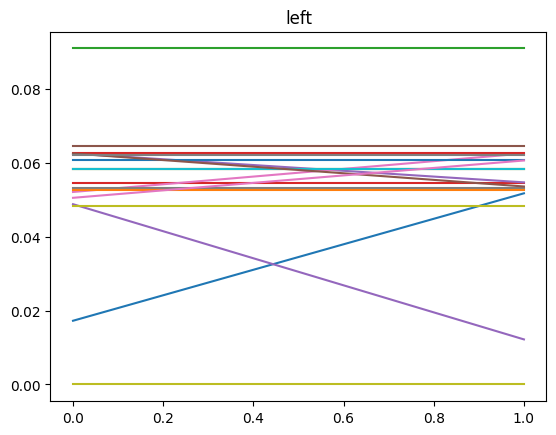

In [53]:

plt.title('left')
for isub, subject in enumerate(subject_list):
    plt.plot([sum_left['speech'][isub], sum_left['music'][isub]])
    print([sum_left['speech'][isub], sum_left['music'][isub]])
plt.show()
plt.close()



In [44]:
re=right_eng[sound][0]
for i in range(len(right_eng[sound])-1):
    re=np.concatenate((re, right_eng[sound][i+1]))

In [11]:
#datatipe="hgenv_down100"
rss={} #here the activity profile of each subject is stored
#data=sv.loading( path+"data_subject_sound_" + datatipe)
for subject in subject_list:
    rss[subject]={}
    avalanches={}
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)
    
    for sound in sound_list:
        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches[sound]=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)

        rss[subject][sound]=np.sum(avalanches[sound]['Zbin'].T, axis=0)
        

2.7657171985646785
2.8054987571064878
2.8576232999584956
2.7522959070291892
2.739843616808106
2.769870267871997
2.775630866006315
2.904463032315214
2.7615563647016867
3.3646615861739533
2.735051936702336
2.8274347846796806
2.816261375628632
2.8082389623586588
2.9766767568705275
2.7921321273109476
2.8090048981322173
2.7353991220595772
2.7678430733802237


Here we create a matrix, whose lines are rss of different subjects

In [30]:

rss_matrix={} 
for sound in sound_list:
    rss_matrix[sound]=np.zeros((len(subject_list), len(rss[subject_list[0]][sound])))
    for isub, subject in enumerate(subject_list):
        rss_matrix[sound][isub,:]=rss[subject][sound]
    

Here the correlation matrices (subject x subject) are computed, using the Pearson correlation. Also using the Spearman correlation the results are significant

In [31]:
corr_matrix={}
for sound in sound_list:
    corr_matrix[sound]=np.corrcoef(rss_matrix[sound])  
    

Here the correlation matrices are plotted.

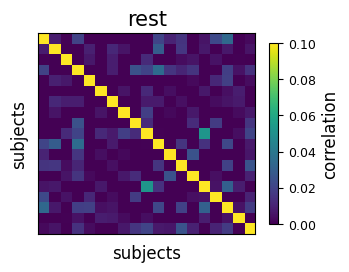

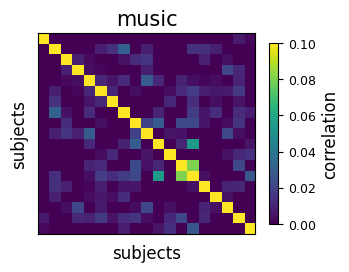

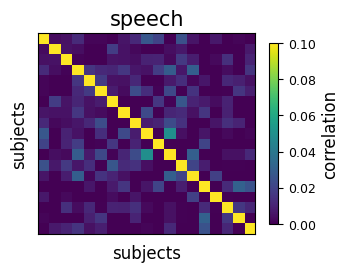

In [32]:
dataused='without_H'
sv.saving(corr_matrix, 'matrix_corr_'+dataused)


for sound in sound_list:
    
    a,b=0,0.1
    plt.figure(figsize=(3.5,2.6))
    plt.imshow(corr_matrix[sound], aspect='auto', vmin=a, vmax=b)
    plt.xticks([])
    plt.yticks([])
    cbar=plt.colorbar(shrink=0.9)
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label('correlation',fontsize=12)
    plt.title(sound,fontsize=15)
    plt.xlabel('subjects',fontsize=12)
    plt.ylabel('subjects',fontsize=12)
    plt.savefig(path+'figure/corr_matrix_'+sound+'_'+dataused+'.png', dpi=600)
    plt.show()
    plt.close()  

Surrogate data procedure

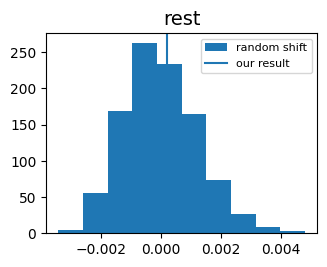

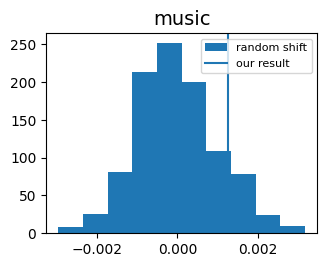

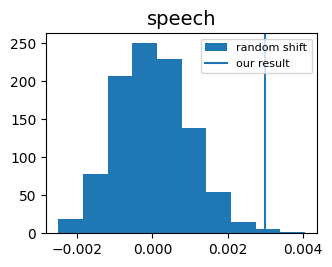

In [33]:
list_mean_corr={}

num_it=1000
for sound in sound_list:
    list_mean_corr[sound]=[]

    for i in range(num_it):

        rss_shift=av.shifting_matrix(rss_matrix[sound])
        list_mean_corr[sound].append(np.mean(np.corrcoef(rss_shift)[np.triu_indices(19, k = 1)]))
for sound in sound_list:
    
    plt.figure(figsize=(3.5,2.6))
    plt.hist(list_mean_corr[sound], label='random shift')
    plt.axvline(x=np.mean(np.corrcoef(rss_matrix[sound])[np.triu_indices(19, k = 1)]), label='our result')
    plt.title(sound, fontsize=14)
    plt.legend(fontsize=8)
    plt.savefig(path+'figure/comparison_null_music_env_'+dataused+'.png', dpi=600)
    plt.show()
    plt.close()
    
sv.saving(list_mean_corr, path+"list_random_correlation_dict_"+dataused)

In [ ]:
##COMPUTING THE DYNAMICAL CORREALTION

In [10]:


window_length=150
time_interval=1
dcorr=dict()
dcorr_matrix={}
dcorr_all={}

#computations
for sound in sound_list:
    dcorr[sound]={}
    dcorr_matrix[sound]=[]
    mat=[]
    
    for isub, subject in enumerate(subject_list):
        dcorr[sound][subject]=[]
        
        for i in np.arange(0,len(rss_matrix[sound][0,:])-window_length, time_interval):
            dcorr[sound][subject].append(np.sum((np.corrcoef(rss_matrix[sound][:,i:i+window_length])-np.identity(19))[isub,:])/18)
        
        #print(len(dcorr[sound][subject]))
        mat.append(dcorr[sound][subject])
        
    dcorr_matrix[sound]=np.array(mat)
    dcorr_all[sound]=np.mean(np.array(mat), axis=0)
    #print('la lunghezza è', dcorr_matrix[sound].shape)

The correlation is saved as dcorr_all_windowlength_timeinterval

In [11]:
sv.saving(dcorr_all, path+'dcorr_all_'+str(window_length)'_1')

SyntaxError: invalid syntax (2760878878.py, line 1)

Plotting the dynamical correlation, in a couple of subjects x time fashion.

No handles with labels found to put in legend.


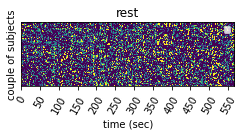

No handles with labels found to put in legend.


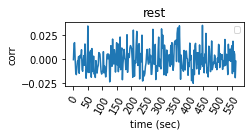

No handles with labels found to put in legend.


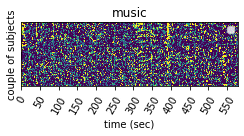

No handles with labels found to put in legend.


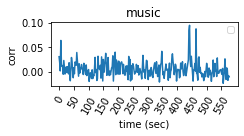

No handles with labels found to put in legend.


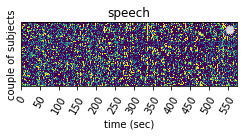

No handles with labels found to put in legend.


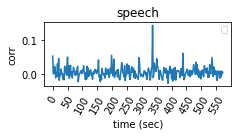

In [107]:
for sound in sound_list:
    
    edge=fc.go_edge(rss_matrix[sound].T)
    #plotting
    plt.figure(figsize=(3.5,2))
    plt.imshow(edge.T, aspect='auto', vmin=a, vmax=b)
    plt.xticks(np.arange(0,len(edge[:,0]),2500), np.arange(0,int(len(edge[:,0])/50),50), rotation=60, fontsize=10 )
    plt.yticks([])
    plt.xlabel('time (sec)', fontsize=10)
    plt.ylabel('couple of subjects', fontsize=10)
    plt.legend(fontsize=8)
    plt.title(sound)
    plt.tight_layout()
    plt.savefig(path+'figure/dynamical_correlation_across_subject_'+sound+'_'+dataused+'.png', dpi=600)
    plt.show()
    plt.close()
    
    
    plt.figure(figsize=(3.5,2))
    plt.plot(dcorr_all[sound][::100])
    plt.xticks(np.arange(0,len(dcorr_all[sound][::100]),25), np.arange(0,len(dcorr_all[sound][::50]),50), rotation=60, fontsize=10)
    plt.xlabel('time (sec)', fontsize=10)
    plt.ylabel('corr', fontsize=10)
    plt.legend(fontsize=8)
    plt.title(sound)
    plt.tight_layout()
    plt.savefig(path+'figure/dynamical_correlation_'+sound+'_'+dataused+'.png', dpi=600)
    plt.show()
    plt.close()
    


## This part concern figure 3, look at the other file ;)

In [267]:
ind={}
ind_all={}

for sound in sound_list:
    
    ind[sound]={}
    corr_thres=np.percentile(dcorr_all[sound], 1)
    ind_all[sound]=np.where(dcorr_all[sound]<corr_thres)[0]
   
    for subject in subject_list:
    
        corr_thres=np.percentile(dcorr[sound][subject], 1)

        ind[sound][subject]=np.where(dcorr[sound][subject]<corr_thres)[0]


In [268]:
index_all=dict()
for sound in sound_list:
    
    aall=set()
    for i in ind_all[sound]:
        aall.update(np.arange(i,i+window_length))
            
    index_all[sound]=list(aall)

m=min(len(index_all['speech']), len(index_all['music']))
print(len(index_all['speech']), len(index_all['music']))
for sound in ['speech', 'music']:
    index_all[sound]=index_all[sound][:m]
    


1755 2672


In [4]:
n_iterations=100000

engagement={}
engagementr={}

meta_engagement={}

engagement_null_mean={}
engagement_null_std={}
engagement_null_mean['speech']={}
engagement_null_std['speech']={}
engagement_null_mean['music']={}
engagement_null_std['music']={}
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)
    
    
    #speech null model
    avalanches=av.go_avalanches(zdata['speech'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['speech'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['speech'][subject]=np.std(engagement_null, axis=0)
    
    
    #music null model
    avalanches=av.go_avalanches(zdata['music'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['music'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['music'][subject]=np.std(engagement_null, axis=0)
    
    
for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    engagementr[sound]={}
    
    meta_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
        print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)

        engagement[sound][subject]=(engagementt-engagement_null_mean[subject])/engagement_null_std[subject]
        
        meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        print(engagement[sound][subject])

NameError: name 'datatipe' is not defined

In [272]:
enga={}
for sound in ['speech','music']:
    enga[sound]={}
    for subject in subject_list:
        thress=5
        thress=max(meta_engagement[sound][subject])
        print(thress, max(engagement[sound][subject]))
        if thress < max(engagement[sound][subject]):
            print('')
            print('yes')
        enga[sound][subject]=np.where(engagement[sound][subject]>thress,1,0)


4.677791575548326 4.914449765944366

yes
2.58439890930716 3.4613846148408856

yes
5.292213033976667 6.089285179001049

yes
7.334158999771594 9.398143517768238

yes
3.9650241372897184 4.135260450438589

yes
5.9919004024602485 4.973612130337533
4.026013527922963 4.187206357931004

yes
3.505728637863862 3.8556202901507683

yes
3.9576981782122296 4.531650598083522

yes
3.655056239982653 6.561716688895085

yes
5.102807090106934 5.7551939837058175

yes
3.56068269507267 3.8754402286584693

yes
3.9896855922739203 3.5596191206864627
3.2762684484714977 2.9158489656999396
4.187977374264003 3.9948229023166957
4.710099746187401 3.6331490422929487
5.605218910271008 6.744711453598278

yes
3.679608391555155 3.318969103159312
2.97911801903452 3.9440026468152434

yes
4.520587398724524 4.909233058986863

yes
2.6247488180714758 2.731744212608186

yes
4.937335996138898 5.348332926222588

yes
5.739323241413671 6.054733864297805

yes
6.001251425311242 5.17562043834826
4.463428953681961 10.33228896923721

yes

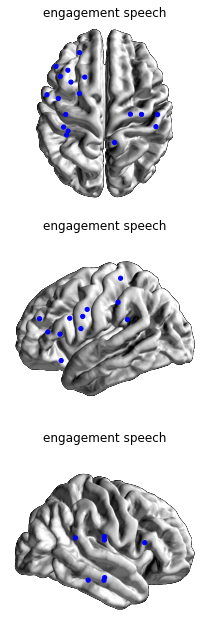

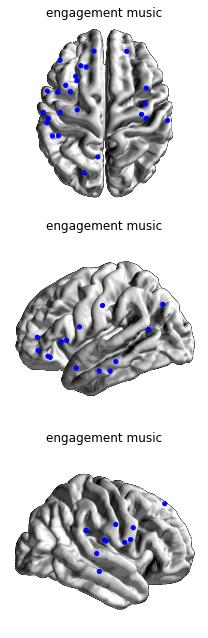

In [274]:

'''
#plotting
plt.figure(figsize=(3,1.7))
for subject in subject_list:
    plt.plot(mean_eng[subject])
plt.title('eng H - all subjects')
plt.xticks([0,1,2], ['speech','music','rest'], fontsize=10)
plt.ylabel('mean eng', fontsize=10)
plt.tight_layout()
plt.savefig(path+'figure/'+ 'engament of H - across conditions - all subjects', dpi=600)
plt.show()
plt.close()'''


        
for o, sound in enumerate(['speech','music']):
    fig, ax= plt.subplots(3,1, figsize=(3,9))
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(engagement[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(engagement[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(engagement[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject]))[i,:]))
                x_h = coordinates
                
                
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color='blue', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject][left_i]))
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color='blue', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject][right_i]))
                
            if orientation =='top':
                axes.scatter(*x_h.T, color='blue', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject]))

                
            axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])
    
    plt.tight_layout()
    plt.savefig(path+'figure/brain_plots_all_channels_troughs_maxmetasound_'+sound+'.png', dpi=600)


In the following part we are going to study the correlation between the dynamical correlation in time window and the engagement in time windows.

1 THE ENGAGEMENT IN TIME WINDOW

In [206]:
n_iterations=400

engagement_null_mean={}
engagement_null_std={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), 200)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)


2.7507264122036497
2.8138171563785437
2.7654285000333187
3.334984151824247
2.7761437719778965
2.9744978125454247
2.774284818922206
2.7985919037396925
2.734310175019014
2.803148765547773
2.8552720483703933
2.78534246404477
2.7331326834817284
2.897258743666651
2.79738475441734
2.750861898649132
2.8089245753814596
2.818625307029934
2.7742837529435107


In [1]:
window_length=50
time_interval=1
d_engagement={}

for sound in ['speech','music']:
    d_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject][sound]
        thres=np.percentile(data[subject]['rest'], 99)
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata.T, thre=thres, direc=0, binsize=2)
        aval=avalanches['Zbin'].T
        t_length=len(aval[0,:])
        n_w=len(np.arange(0, t_length - window_length, time_interval))
        d_engagement[sound][subject]=np.zeros((len(aval),n_w))
        
        print(d_engagement[sound][subject].shape)
        windows=np.arange(0, t_length- window_length, time_interval)
        for i in range(n_w):
            t_start=windows[i]
            d_engagement[sound][subject][:,i] =(np.sum(aval[:,t_start:t_start+window_length], axis=1)
            
            
            
            
            


SyntaxError: unexpected EOF while parsing (Temp/ipykernel_29552/2542010369.py, line 27)

In [212]:
len(np.arange(0, - window_length, time_interval))

143

In [215]:
(len(aval[0,:])-window_length)/time_interval


142.675

In [222]:


#computations
for sound in sound_list:
    dcorr[sound]={}
    dcorr_matrix[sound]=[]
    mat=[]
    
    for isub, subject in enumerate(subject_list):
        dcorr[sound][subject]=[]
        
        for i in np.arange(0,len(rss_matrix[sound][0,:])-window_length, time_interval):
            dcorr[sound][subject].append(np.sum((np.corrcoef(rss_matrix[sound][:,i:i+window_length])-np.identity(19))[isub,:])/18)
        
        #print(len(dcorr[sound][subject]))
        mat.append(dcorr[sound][subject])
        
    dcorr_matrix[sound]=np.array(mat)
    dcorr_all[sound]=np.mean(np.array(mat), axis=0)
    print('la lunghezza è', dcorr_matrix[sound].shape)

la lunghezza è (19, 141)
la lunghezza è (19, 144)
la lunghezza è (19, 143)


In [229]:
ch_H_i


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114]

The results of this computation

In [173]:
d_engagement['speech'][subject]=np.array(d_engagement['speech'][subject])

In [165]:
final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in ch_H_i]
        final_channels_all[subject]final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in ch_H_i]
        final_channels_all[subject]

(57787, 115)

In [13]:
plt.plot(dcorr_all['speech'], np.mean(d_engagement['speech'][subject_list[8]], axis=0), 'o')

NameError: name 'dcorr_all' is not defined

In [250]:
sr={}
pval={}
for sound in ['speech', 'music']:
    sr[sound]={}
    pval[sound]={}
    for subject in subject_list:
        ch_i=[i for i, ch in enumerate(final_channels_all[subject]) if ch in final_channels_H]
        print(ch_i)
        n_ch=len(d_engagement[sound][subject][ch_i, :])
        sr[sound][subject]=np.zeros(n_ch)
        pval[sound][subject]=np.zeros(n_ch)

        
        for ch in ch_i:
            sr[sound][subject][ch], pval[sound][subject][ch] = stats.spearmanr(dcorr_all[sound], d_engagement[sound][subject][ch,:])


        
        

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


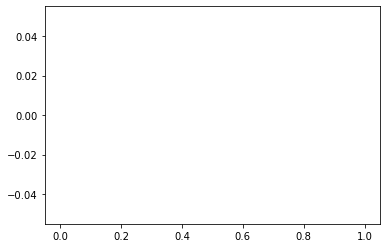

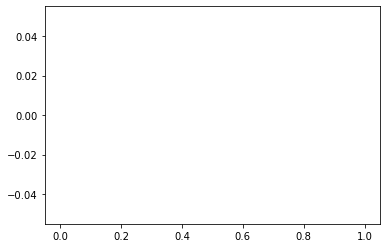

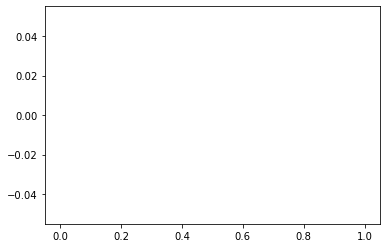

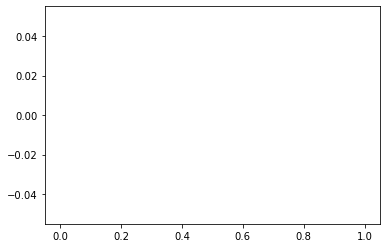

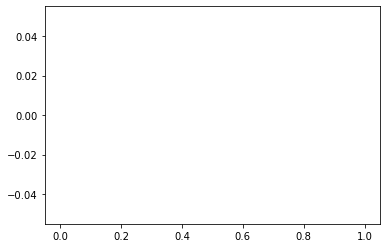

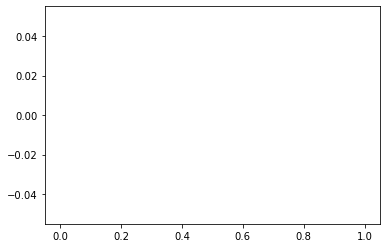

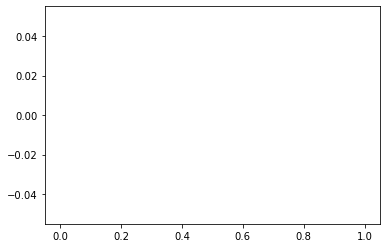

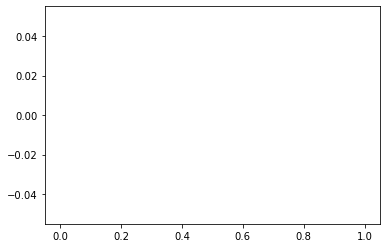

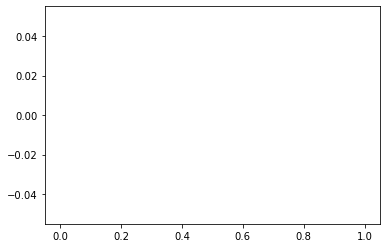

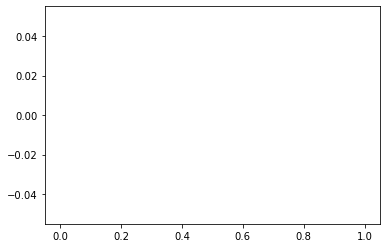

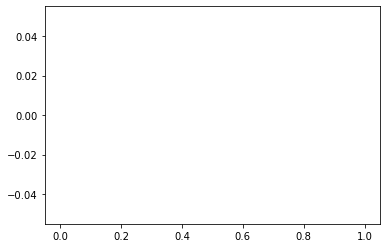

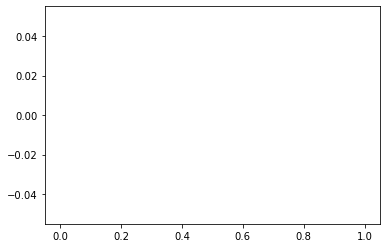

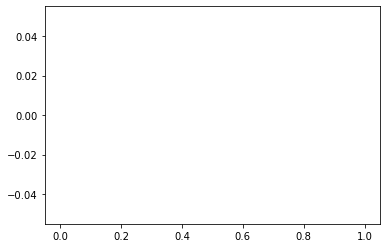

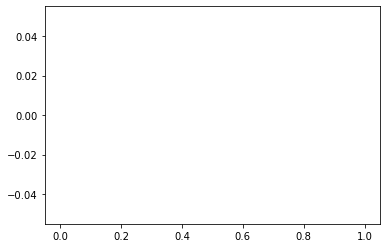

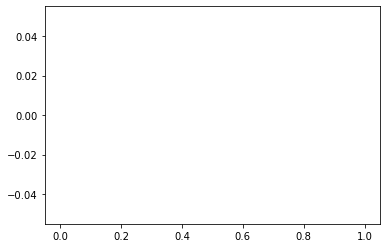

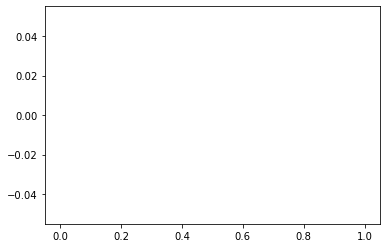

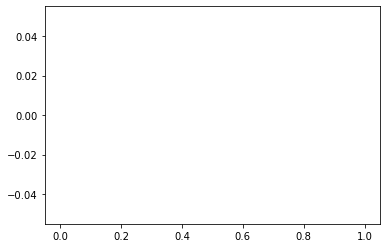

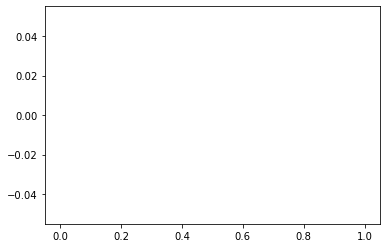

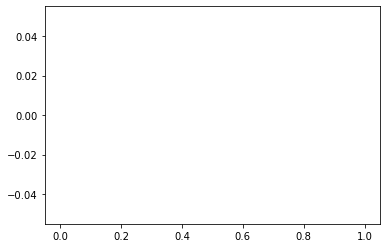

In [249]:
for subject in subject_list:
    
    for sound in ['music','speech']:
        plt.hist(sr[sound][subject])
    plt.show()
    plt.close()

In [176]:
d_engagement['speech'][subject][5,:]


array([-3.64271566, -3.64271566, -3.64271566, ..., -3.64271566,
       -3.64271566, -3.64271566])

In [150]:
index=dict()
for sound in sound_list:
    
    index[sound]={}
    for subject in subject_list:

        aa=set()
        for i in ind[sound][subject]:
            aa.update(np.arange(i,i+window_length))
            
        index[sound][subject]=list(aa)

            
for subject in subject_list:
    m=min(len(index['speech'][subject]), len(index['music'][subject]))
    for sound in ['speech', 'music']:
        index[sound][subject]=index[sound][subject][:m]
        

The indices of the time steps of the binarized dataset corresponding to the most correlated time windows (computed above), are computed in the following way. Below is for the moment when each subject is particularly correlated with the others.

In [114]:

#%%
entropy=dict()
mean_eng=dict()
burstiness=dict()
n_iterations=100
engagement=dict()
engagementr={}
engagement_null_mean={}
engagement_null_std={}

sound='rest'
for isub, subject in enumerate(subject_list):
    
    zdata=sv.loading( path+"data_"+datatipe+'_'+subject) #loading the data of the three conditions that we saved before 

    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
        
    m=len(list(index['speech'][subject]))
    print(m, len(list(index['music'][subject])))      

            
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)
        
for sound in ['music', 'speech']:
    engagement[sound]={}
    engagementr[sound]={}
    
    for subject in subject_list:
        zdata=sv.loading( path+"data_"+datatipe+'_'+subject) #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)
        
        
        corr_thres=np.percentile(dcorr[sound][subject], 99)
        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index[sound][subject],:]

        engagementt=np.sum(aval, axis=0)

        engagement[sound][subject]=(engagementt-engagement_null_mean[subject])/engagement_null_std[subject]
            
        engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        print(engagement[sound][subject])

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/matte/OneDrive/Documenti/matteo/data_hgenv_down100_sub-14c725b6b803'